# Ichigo - Machine Learning Model

In [26]:
# Utilities
import os
import re
import pickle

# NLP
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwd = stopwords.words('spanish')

# Data
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Graphs
import seaborn as sns

[nltk_data] Downloading package punkt to /Users/javier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Extract/Transform Data

In [27]:
base_path = '../data/intents'

files = os.listdir('../data/intents')
df_list = []
for file in files:
  df_temp = pd.read_csv(f'{base_path}/{file}', header=0, names=['question'])
  df_temp['intent'] = file.split('.')[0]
  df_list.append(df_temp)

df = pd.concat(df_list)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df.describe(include="all")

,question,intent
count,300,300
unique,86,9
top,cual es su vision,ubicacion
freq,4,39


In [28]:
all_tokens = [ w for s in df['question'] for w in word_tokenize(s) if w not in stopwd and re.match('\w', w) ]

# Tokens
freq_dist_tokens = nltk.collocations.FreqDist(all_tokens)

# Bigrams
bigrams = nltk.bigrams(all_tokens)
freq_dist_bigrams = nltk.collocations.FreqDist(bigrams)


In [29]:
[ w for s in df['question'] for w in word_tokenize(s) if w not in stopwd and re.match('\w', w) ]

# Tokens
freq_dist_tokens = nltk.collocations.FreqDist(all_tokens)

# Bigrams
bigrams = nltk.bigrams(all_tokens)
freq_dist_bigrams = nltk.collocations.FreqDist(bigrams)


In [30]:
most_common_tokens = freq_dist_tokens.most_common(20)
list_tokens = [w[0] for w in list(most_common_tokens)]
for i in list_tokens:
  df[i] = 0

In [31]:
most_common_bigrams = freq_dist_bigrams.most_common(20)
list_bigrams = [w[0] for w in list(most_common_bigrams)]
for i in list_bigrams:
  df[i] = 0

In [32]:
def transform(arr, col) -> list:
  tokens = [ w for w in word_tokenize(arr[0]) if w not in stopwd and re.match('\w', w) ]
  bigrams = list(nltk.bigrams(tokens))

  for idx, ele in enumerate(col):
    if ele in tokens: 
      arr[idx] = 1
    elif len(bigrams):
      for b in bigrams:
        if ele[0] == b[0] and ele[1] == b[1]:
          arr[idx] = 1

  return arr

## Train/Test Split 

In [33]:
col = df.columns
str_col = [str(c) for c in col]
matrix = []
for i in df.index:
  arr = transform(df.iloc[i].array, col)
  matrix.append(arr)

df_train = pd.DataFrame(matrix, columns=str_col)

In [34]:
X = df_train[str_col]
X.drop(columns=['question', 'intent'], inplace=True)

y = df_train['intent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Gaussian Naive Bayes

In [48]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X, y) # PROD
# gnb = gnb.fit(X_train, y_train) # DEV
y_pred = gnb.predict(X_test)

gnb_score = {
     "model": "gnb",
     "train": gnb.score(X_train, y_train),
     "test": gnb.score(X_test, y_test)
}

print('Accuracy of GBN classifier on training set: {:.2f}%'
     .format(gnb_score['train']))
print('Accuracy of GBN classifier on test set: {:.2f}%'
     .format(gnb_score['test']))

Accuracy of GBN classifier on training set: 0.67%
Accuracy of GBN classifier on test set: 0.67%


<AxesSubplot:>

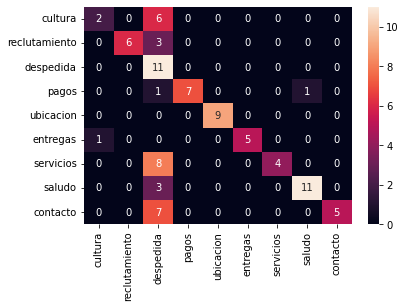

In [36]:
matrix_data = confusion_matrix(y_test, y_pred)
matrix_graph = pd.DataFrame(matrix_data,
  index=df['intent'].unique(),
  columns=df['intent'].unique()
)
sns.heatmap(matrix_graph, annot=True, fmt=".0f" )

In [37]:
print(classification_report(y_test, y_pred, zero_division=0))

               precision    recall  f1-score   support

     contacto       0.67      0.25      0.36         8
      cultura       1.00      0.67      0.80         9
    despedida       0.28      1.00      0.44        11
     entregas       1.00      0.78      0.88         9
        pagos       1.00      1.00      1.00         9
reclutamiento       1.00      0.83      0.91         6
       saludo       1.00      0.33      0.50        12
    servicios       0.92      0.79      0.85        14
    ubicacion       1.00      0.42      0.59        12

     accuracy                           0.67        90
    macro avg       0.87      0.67      0.70        90
 weighted avg       0.87      0.67      0.69        90



## Logistic Regresion

In [50]:
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression(random_state=0).fit(X, y)

y_pred_2 = lrc.predict(X_test)

lrc_score = {
     "model": "lrc",
     "train": lrc.score(X_train, y_train),
     "test": lrc.score(X_test, y_test)
}

print('Accuracy of LRC classifier on training set: {:.2f}%'
     .format(lrc_score['train']))
print('Accuracy of LRC classifier on test set: {:.2f}%'
     .format(lrc_score['test']))

Accuracy of LRC classifier on training set: 0.71%
Accuracy of LRC classifier on test set: 0.68%


<AxesSubplot:>

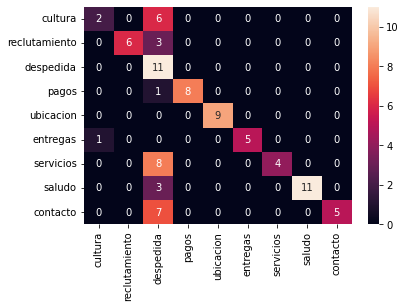

In [39]:
matrix_data = confusion_matrix(y_test, y_pred_2)
matrix_graph = pd.DataFrame(matrix_data,
  index=df['intent'].unique(),
  columns=df['intent'].unique()
)
sns.heatmap(matrix_graph, annot=True, fmt=".0f" )

In [40]:
print(classification_report(y_test, y_pred_2, zero_division=0))

               precision    recall  f1-score   support

     contacto       0.67      0.25      0.36         8
      cultura       1.00      0.67      0.80         9
    despedida       0.28      1.00      0.44        11
     entregas       1.00      0.89      0.94         9
        pagos       1.00      1.00      1.00         9
reclutamiento       1.00      0.83      0.91         6
       saludo       1.00      0.33      0.50        12
    servicios       1.00      0.79      0.88        14
    ubicacion       1.00      0.42      0.59        12

     accuracy                           0.68        90
    macro avg       0.88      0.69      0.71        90
 weighted avg       0.88      0.68      0.70        90



## Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=2, random_state=0).fit(X, y)

y_pred_3 = rfc.predict(X_test)

rfc_score = {
     "model": "rfc",
     "train": rfc.score(X_train, y_train),
     "test": rfc.score(X_test, y_test)
}

print('Accuracy of RFC classifier on training set: {:.2f}%'
     .format(rfc_score['train']))
print('Accuracy of RFC classifier on test set: {:.2f}%'
     .format(rfc_score['test']))

Accuracy of RFC classifier on training set: 0.56%
Accuracy of RFC classifier on test set: 0.57%


<AxesSubplot:>

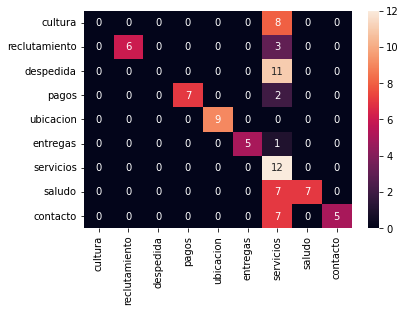

In [42]:
matrix_data = confusion_matrix(y_test, y_pred_3)
matrix_graph = pd.DataFrame(matrix_data,
  index=df['intent'].unique(),
  columns=df['intent'].unique()
)
sns.heatmap(matrix_graph, annot=True, fmt=".0f" )

In [43]:
print(classification_report(y_test, y_pred_3, zero_division=0))

               precision    recall  f1-score   support

     contacto       0.00      0.00      0.00         8
      cultura       1.00      0.67      0.80         9
    despedida       0.00      0.00      0.00        11
     entregas       1.00      0.78      0.88         9
        pagos       1.00      1.00      1.00         9
reclutamiento       1.00      0.83      0.91         6
       saludo       0.24      1.00      0.38        12
    servicios       1.00      0.50      0.67        14
    ubicacion       1.00      0.42      0.59        12

     accuracy                           0.57        90
    macro avg       0.69      0.58      0.58        90
 weighted avg       0.69      0.57      0.56        90



In [52]:
from sklearn.linear_model import Perceptron
pc = Perceptron(tol=1e-3, random_state=0).fit(X, y)

y_pred_4 = pc.predict(X_test)

pc_score = {
     "model": "pc",
     "train": pc.score(X_train, y_train),
     "test": pc.score(X_test, y_test)
}

print('Accuracy of PC classifier on training set: {:.2f}%'
     .format(pc_score['train']))
print('Accuracy of PC classifier on test set: {:.2f}%'
     .format(pc_score['test']))

Accuracy of PC classifier on training set: 0.64%
Accuracy of PC classifier on test set: 0.62%


<AxesSubplot:>

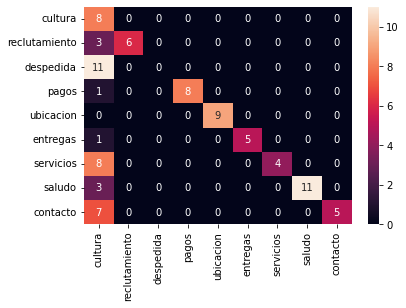

In [45]:
matrix_data = confusion_matrix(y_test, y_pred_4)
matrix_graph = pd.DataFrame(matrix_data,
  index=df['intent'].unique(),
  columns=df['intent'].unique()
)
sns.heatmap(matrix_graph, annot=True, fmt=".0f" )

In [46]:
print(classification_report(y_test, y_pred_4, zero_division=0))

               precision    recall  f1-score   support

     contacto       0.19      1.00      0.32         8
      cultura       1.00      0.67      0.80         9
    despedida       0.00      0.00      0.00        11
     entregas       1.00      0.89      0.94         9
        pagos       1.00      1.00      1.00         9
reclutamiento       1.00      0.83      0.91         6
       saludo       1.00      0.33      0.50        12
    servicios       1.00      0.79      0.88        14
    ubicacion       1.00      0.42      0.59        12

     accuracy                           0.62        90
    macro avg       0.80      0.66      0.66        90
 weighted avg       0.81      0.62      0.65        90



## Comparative

In [53]:
report = pd.DataFrame(columns=["model", "train", "test"],
  data=[gnb_score, lrc_score, rfc_score, pc_score])

report.head()

,model,train,test
0,gnb,0.671429,0.666667
1,lrc,0.714286,0.677778
2,rfc,0.561905,0.566667
3,pc,0.638095,0.622222


In [47]:
pickle.dump({
  "model": gnb,
  "columns": col 
}, open('../model/IchigoModel.v1.pckl','wb'))